# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
import datetime
warnings.filterwarnings("ignore")

In [191]:
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [192]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [194]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [195]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

In [196]:
df.shape

(26496, 1)

In [197]:
df.isnull().sum()

num_orders    0
dtype: int64

In [198]:
# resample data by hour
hourly_df = df.resample('1H').sum()

In [199]:
hourly_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [200]:
hourly_df.shape

(4416, 1)

In [201]:
hourly_df.isnull().sum()

num_orders    0
dtype: int64

Our raw dataset includes 26,496 rows of data from 12:00 AM March 1, 2018 through 11:50 PM August 31, 2018 so we have exactly 6 months of data to use for our time series analysis. 

After resampling the data by the hour, we have 4,416 rows of data and no missing values.

## Analysis

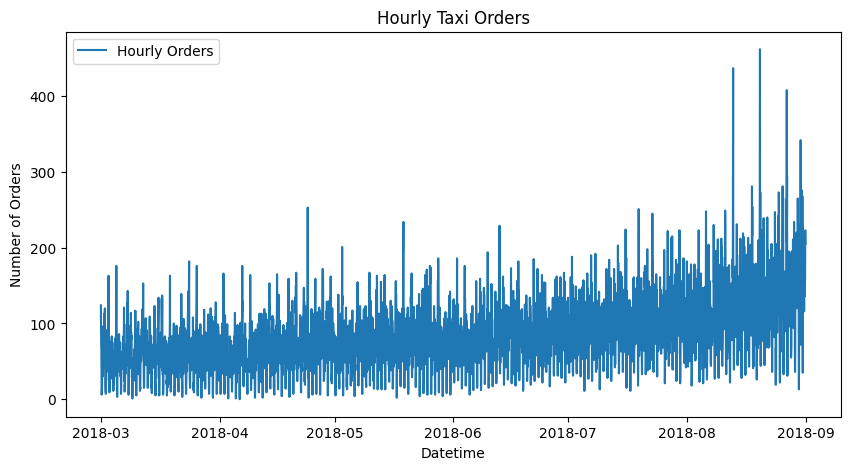

In [202]:
# Plot hourly taxi orders for full dataset
plt.figure(figsize=(10, 5))
plt.plot(hourly_df, label='Hourly Orders')
plt.title('Hourly Taxi Orders')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

From our initial look at our data, we can see that we have a positive trend of taxi orders over the 6 month time span. Possibly some seasonality with spikes on certain days. We'll take a closer look below.

Now we'll take a look at seasonality and trends by day.

Text(0.5, 1.0, 'Trend')

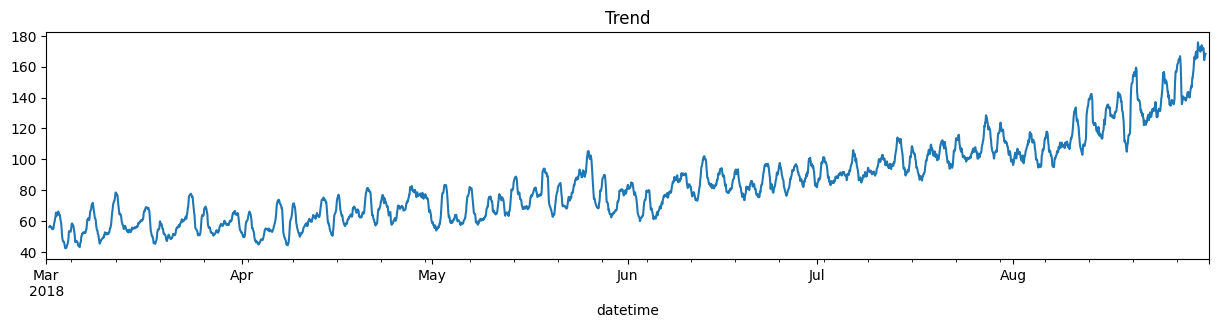

In [203]:
decomposed = seasonal_decompose(hourly_df, 'additive', period=24)

plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Trend')

Text(0.5, 1.0, 'Seasonal')

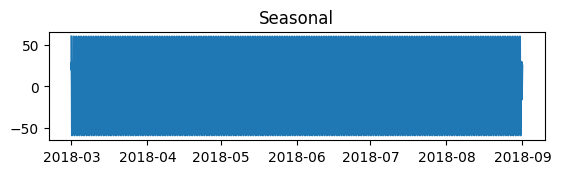

In [204]:
plt.subplot(312)
plt.plot(decomposed.seasonal)
plt.title('Seasonal')

We see some seasonality here with the repeating pattern which we'll take a closer look at below.

Text(0.5, 1.0, 'Residual')

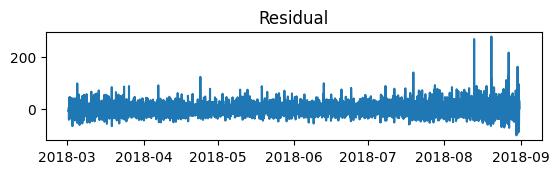

In [205]:
plt.subplot(313)
plt.plot(decomposed.resid)
plt.title('Residual')

Here are the residuals which is just the noise of the data that we can't do anything with. It is what is leftover after we take the trend and seasonality from our original time series graph.

Now we'll take a closer look at our seasonal pattern in a 24 hour period.

In [206]:
# create half hour labels for 24 hour period
half_hour_labels = [f"{hour:02}:{minute:02}" for hour in range(24) for minute in (0, 30)]


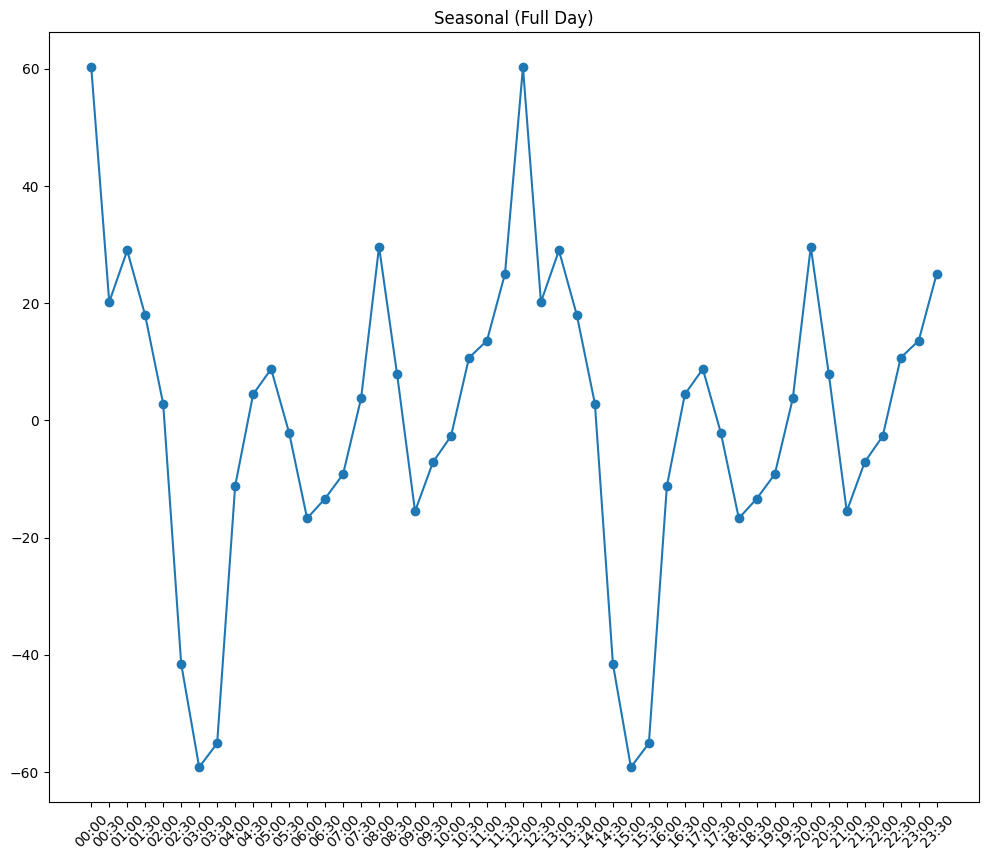

In [207]:
plt.figure(figsize=(12,10))
plt.plot(half_hour_labels, decomposed.seasonal[24:72], marker='o')
plt.title('Seasonal (Full Day)')
plt.xticks(rotation=45);

We can see a seasonal trend where the number of taxi orders drastically decrease between 2:30 and 3:00 AM and also 2:30 - 3:00 PM. They peak at 12:00 AM and 12:00 PM.

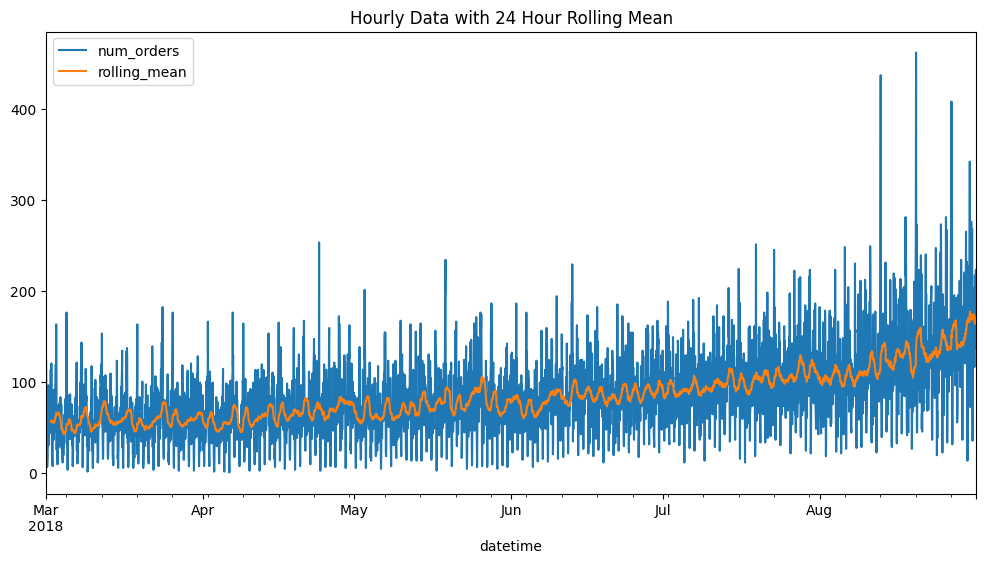

In [208]:
hourly_df['rolling_mean'] = hourly_df.rolling(24).mean()
hourly_df.plot(figsize=(12, 6))
plt.title('Hourly Data with 24 Hour Rolling Mean')
plt.show()

We were able to reduce some of the noise by using the rolling mean and looking at a window size of 24 to help visualize the pattern over a 24 hour period. Since our mean changes, this suggests that our data is nonstationary and our mean is increasing over the months. 

## Training

In [209]:
# check that our hourly_df is a DataFrame and not a Series
print(type(hourly_df))

<class 'pandas.core.frame.DataFrame'>


In [210]:
# create features for modeling. 

def make_features(hourly_df, max_lag, rolling_mean_size):
    hourly_df['year'] = hourly_df.index.year
    hourly_df['month'] = hourly_df.index.month
    hourly_df['day'] = hourly_df.index.day
    hourly_df['dayofweek'] = hourly_df.index.dayofweek
    hourly_df['hour'] = hourly_df.index.hour
    hourly_df['is_weekend'] = (hourly_df.index.dayofweek >= 5).astype(int)
    
    for lag in range(1, max_lag + 1):
        hourly_df['lag_{}'.format(lag)] = hourly_df['num_orders'].shift(lag)

    for window in rolling_mean_size:
        hourly_df['rolling_mean_{}'.format(window)] = hourly_df['num_orders'].shift(1).rolling(window=window).mean()
    
make_features(hourly_df, max_lag=22, rolling_mean_size=[1, 3, 6, 12])

Since our data is trending upwards over the time series and our test data set has a higher mean than the training and validation sets, we'll use multiple window sizes for the rolling mean to help capture short term and long term trends.

In [211]:
hourly_df.shape

(4416, 34)

In [212]:
hourly_df.head()

,num_orders,rolling_mean,year,month,day,dayofweek,hour,is_weekend,lag_1,lag_2,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,rolling_mean_1,rolling_mean_3,rolling_mean_6,rolling_mean_12
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,1,0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,2,0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,3,0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,71.0,93.333333,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,4,0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,74.000000,NaN,NaN


In [213]:
# drop missing values created by lag features
hourly_df = hourly_df.dropna()

In [214]:
hourly_df.shape

(4393, 34)

In [215]:
# split data into training, validation, and test sets
test_size = 0.1

train_valid, test = train_test_split(hourly_df, shuffle=False, test_size=test_size)

valid_size = test_size / (1 - test_size)

train, valid = train_test_split(train_valid, shuffle=False, test_size=valid_size)

In [216]:
print(f"Training set size: {train.shape}")
print(f"Validation set size: {valid.shape}")
print(f"Test set size: {test.shape}")

Training set size: (3513, 34)
Validation set size: (440, 34)
Test set size: (440, 34)


In [217]:
# Check splits
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

print()

print(f"Original dataset size: {hourly_df.shape}")
print(f"Training+Validation set size: {train_valid.shape}")
print(f"Training set size: {train.shape}")
print(f"Validation set size: {valid.shape}")
print(f"Test set size: {test.shape}")

2018-03-01 23:00:00 2018-07-26 07:00:00
2018-07-26 08:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00

Original dataset size: (4393, 34)
Training+Validation set size: (3953, 34)
Training set size: (3513, 34)
Validation set size: (440, 34)
Test set size: (440, 34)


In [218]:
# declare feature and target variables
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [219]:
# function to calculate rmse

def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

In [220]:
# Use Median prediction and naive forecasting as baseline for sanity checking models

from sklearn.metrics import mean_absolute_error

# Sanity Check: Median Prediction
median_value = target_train.median()
print('Median hourly taxi orders:', median_value)
pred_median = np.full(target_test.shape, median_value)
rmse_median = rmse(target_test, pred_median)
print('RMSE (Median Prediction):', rmse_median)


# Sanity Check: Naive Forecasting
pred_previous = target_test.copy()
pred_previous.iloc[0] = target_train.iloc[-1] # Set the first prediction to the last value of y_train
pred_previous[1:] = target_test[:-1] # Use previous values for predictions

rmse_naive = rmse(target_test, pred_previous)
print("RMSE (Naive Forecasting):", rmse_naive)


# Calculate the average of actual values
average_actual = target_test.mean()

# Calculate percentage error rates
percentage_error_rate_median = (rmse_median / average_actual) * 100
percentage_error_rate_naive = (rmse_naive / average_actual) * 100

print('Percentage Error Rate (Median Prediction):', percentage_error_rate_median)
print('Percentage Error Rate (Naive Forecasting):', percentage_error_rate_naive)

Median hourly taxi orders: 72.0
RMSE (Median Prediction): 89.45454660938654
RMSE (Naive Forecasting): 59.07568335310531
Percentage Error Rate (Median Prediction): 64.09692788791193
Percentage Error Rate (Naive Forecasting): 42.32954007746078


We have the median hourly taxi orders for our training set as 72 orders. Based off of just predicting the next hours orders, we get a RMSE of 89.45 and a percentage error rate of 64%. The high percentage error rate tells us that the prediction may be far off from the actual values.

<br>

As for the naive forecasting, we have a lower RMSE of 59.08 with a percentage error rate of 42%. This tells us that using previous predictions will be more accurate than simply predicting alone. We expect our models using previous taxi order predictions to be much more accurate than our naive forecasting. 

**Linear Regression**

In [221]:
# train linear regression model
lr = LinearRegression()
lr.fit(features_train, target_train)

pred_train = lr.predict(features_train)
pred_valid = lr.predict(features_valid)

rmse_train = rmse(target_train, pred_train)
rmse_valid = rmse(target_valid, pred_valid)

print("LR RMSE on training set:", rmse_train)
print("LR RMSE on validation set:", rmse_valid)

print()

# Calculate average actual values for train and valid sets
average_actual_train = target_train.mean()
average_actual_valid = target_valid.mean()

# Calculate percentage error rates
percentage_error_rate_train = (rmse_train / average_actual_train) * 100
percentage_error_rate_valid = (rmse_valid / average_actual_valid) * 100

print('Percentage Error Rate (Train):', percentage_error_rate_train)
print('Percentage Error Rate (Valid):', percentage_error_rate_valid)

LR RMSE on training set: 16.77727489497371
LR RMSE on validation set: 22.274358806551554

Percentage Error Rate (Train): 22.545373651047978
Percentage Error Rate (Valid): 20.134599956616576


**Observation** Our LinearRegression model performs better than our naive forecasting on both the training and validation sets with much lower RMSE values and percentage error rates. A higher RMSE on the validation set suggests that the model might not generalize perfectly on unseen data but it's performance is still within acceptable range.

**Random Forest**

In [222]:
# train Random Forest Model
rf = RandomForestRegressor(n_estimators=3, random_state=54321)

rf.fit(features_train, target_train)
rf_pred_train = rf.predict(features_train)
rf_pred_valid = rf.predict(features_valid)


# Calculate RMSE
rf_rmse_train = rmse(target_train, rf_pred_train)
rf_rmse_valid = rmse(target_valid, rf_pred_valid)


print("RF RMSE train:", rf_rmse_train)
print("RF RMSE Valid:", rf_rmse_valid)

print()

# Calculate average actual values for train and valid sets
average_actual_train = target_train.mean()
average_actual_valid = target_valid.mean()

# Calculate percentage error rates
percentage_error_rate_train = (rf_rmse_train / average_actual_train) * 100
percentage_error_rate_valid = (rf_rmse_valid / average_actual_valid) * 100

print('Percentage Error Rate (Train):', percentage_error_rate_train)
print('Percentage Error Rate (Valid):', percentage_error_rate_valid)

RF RMSE train: 12.447454158704577
RF RMSE Valid: 34.52593447707319

Percentage Error Rate (Train): 16.72694205519397
Percentage Error Rate (Valid): 31.209243097033866


The RMSE on the training set came back lower than our Linear Regression model, however, it is high on the validation set. This suggest overfitting of the model. We'd rather not have an overfitted model, so Linear Regression is still best for this data.

In [223]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=54321, max_depth=10, min_samples_leaf=5)
dt.fit(features_train, target_train)

dt_pred_train = dt.predict(features_train)
dt_pred_valid = dt.predict(features_valid)

dt_rmse_train = rmse(target_train, dt_pred_train)
dt_rmse_valid = rmse(target_valid, dt_pred_valid)

print("DT RMSE train:", dt_rmse_train)
print("DT RMSE Valid:", dt_rmse_valid)

print()

# Calculate average actual values for train and valid sets
average_actual_train = target_train.mean()
average_actual_valid = target_valid.mean()

# Calculate percentage error rates
percentage_error_rate_train = (dt_rmse_train / average_actual_train) * 100
percentage_error_rate_valid = (dt_rmse_valid / average_actual_valid) * 100

print('Percentage Error Rate (Train):', percentage_error_rate_train)
print('Percentage Error Rate (Valid):', percentage_error_rate_valid)

DT RMSE train: 16.41638343741985
DT RMSE Valid: 35.16459503359195

Percentage Error Rate (Train): 22.060406169203787
Percentage Error Rate (Valid): 31.786551513642163


The results of the Decision Tree are okay but still suggest overfitting. Especially after a trial run with no parameter tuning, the model made perfect predictions which is an overfitted model. 

## Grid Search

In [224]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

brf = RandomForestRegressor(random_state=54321)

param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 10]
    
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=brf, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error')

grid_search.fit(features_train, target_train)

best_rf = grid_search.best_estimator_

print("Best parameters found:", grid_search.best_params_)

pred_valid = best_rf.predict(features_valid)
rmse_valid = rmse(target_valid, pred_valid)

print("Tuned RF RMSE on validation set:", rmse_valid)

Best parameters found: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}
Tuned RF RMSE on validation set: 31.228901072437058


## Testing

In [225]:
# Linear Regression Test Data
lr_pred_test = lr.predict(features_test)
lr_rmse_test = rmse(target_test, lr_pred_test)
print("LR RMSE on test set:", lr_rmse_test)

print()

average_actual_test = target_test.mean()
percentage_error_rate_test = (lr_rmse_test / average_actual_test) * 100
print('Percentage Error Rate (Test):', percentage_error_rate_test)

LR RMSE on test set: 27.131307519082334

Percentage Error Rate (Test): 19.44041446153733


In [226]:
# Random Forest Test Data
rf_pred_test = rf.predict(features_test)
rf_rmse_test = rmse(target_test, rf_pred_test)
print("RF RMSE on test set:", rf_rmse_test)

print()

average_actual_test = target_test.mean()
percentage_error_rate_test = (rf_rmse_test / average_actual_test) * 100
print('Percentage Error Rate (Test):', percentage_error_rate_test)

RF RMSE on test set: 58.7642589616608

Percentage Error Rate (Test): 42.106394943786135


In [227]:
# Best RF model
brf_pred_test = best_rf.predict(features_test)
brf_rmse_test = rmse(target_test, brf_pred_test)
print("BRF RMSE on test set:", brf_rmse_test)

print()

average_actual_test = target_test.mean()
percentage_error_rate_test = (brf_rmse_test / average_actual_test) * 100
print('Percentage Error Rate (Test):', percentage_error_rate_test)

BRF RMSE on test set: 52.24192048531923

Percentage Error Rate (Test): 37.43293926350491


In [228]:
# Decision Tree Test Data
dt_pred_test = dt.predict(features_test)
dt_rmse_test = rmse(target_test, dt_pred_test)
print("DT RMSE on test set:", dt_rmse_test)

print()

average_actual_test = target_test.mean()
percentage_error_rate_test = (dt_rmse_test / average_actual_test) * 100
print('Percentage Error Rate (Test):', percentage_error_rate_test)

DT RMSE on test set: 54.6197797366991

Percentage Error Rate (Test): 39.13674839048904


## Conclusion
<br>
For this dataset, we can see that we have daily and hourly seasonality and an upwards trend over the time series. A Linear Regression model has proven to be the most effective model for predicting taxi orders, achieving an RMSE score of 27.13 on the test dataset and a Percentage Error Rate of 19%. We used a max_lag of the 22 hours previous and a rolling mean window size up to 12. Although these results are not perfect, Linear Regression has shown to be a reliable baseline model.

As more data becomes available, there is potential to further improve the model's performance. With additional data, we can revisit the model and consider more advanced techniques or feature engineering strategies to enhance prediction accuracy.